In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install scipy librosa tensorflow h5py


In [3]:
import os
import numpy as np
import scipy.io
import librosa
import librosa.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt


In [4]:
data_path = '/content/drive/MyDrive/data'
adhd_path = os.path.join(data_path, 'ADHD')
control_path = os.path.join(data_path, 'control')
save_model_path = '/content/drive/MyDrive/saved_models'
os.makedirs(save_model_path, exist_ok=True)


In [5]:
import scipy.io
import os

def inspect_mat_file(file_path):
    mat_data = scipy.io.loadmat(file_path)
    keys = [key for key in mat_data.keys() if not key.startswith("__")]
    print(f"Keys in {os.path.basename(file_path)}: {keys}")

def inspect_all_files(folder_path):
    print(f"\nInspecting files in: {folder_path}\n")
    for file in os.listdir(folder_path):
        if file.endswith('.mat'):
            inspect_mat_file(os.path.join(folder_path, file))

adhd_path = os.path.join(data_path, 'ADHD')
control_path = os.path.join(data_path, 'control')

inspect_all_files(adhd_path)
inspect_all_files(control_path)




Inspecting files in: /content/drive/MyDrive/data/ADHD

Keys in v25p.mat: ['v25p']
Keys in v30p.mat: ['v30p']
Keys in v35p.mat: ['v35p']
Keys in v31p.mat: ['v31p']
Keys in v32p.mat: ['v32p']
Keys in v29p.mat: ['v29p']
Keys in v37p.mat: ['v37p']
Keys in v28p.mat: ['v28p']
Keys in v33p.mat: ['v33p']
Keys in v34p.mat: ['v34p']
Keys in v24p.mat: ['v24p']
Keys in v27p.mat: ['v27p']
Keys in v36p.mat: ['v36p']
Keys in v8p.mat: ['v8p']
Keys in v38p.mat: ['v38p']
Keys in v6p.mat: ['v6p']
Keys in v39p.mat: ['v39p']
Keys in v3p.mat: ['v3p']
Keys in v40p.mat: ['v40p']
Keys in v250.mat: ['v250']
Keys in v246.mat: ['v246']
Keys in v244.mat: ['v244']
Keys in v254.mat: ['v254']
Keys in v265.mat: ['v265']
Keys in v274.mat: ['v274']
Keys in v270.mat: ['v270']
Keys in v288.mat: ['v288']
Keys in v263.mat: ['v263']
Keys in v286.mat: ['v286']
Keys in v279.mat: ['v279']
Keys in v284.mat: ['v284']
Keys in v10p.mat: ['v10p']
Keys in v12p.mat: ['v12p']
Keys in v14p.mat: ['v14p']
Keys in v173.mat: ['v173']
Keys 

In [6]:
import scipy.io
import os
import numpy as np

def load_eeg_data(file_path):
    mat_data = scipy.io.loadmat(file_path)
    keys = [key for key in mat_data.keys() if not key.startswith("__")]

    if not keys:
        print(f"Warning: No valid keys found in {os.path.basename(file_path)}")
        return None

    key = keys[0]
    eeg_data = mat_data[key]

    if not isinstance(eeg_data, np.ndarray):
        print(f"Warning: Data in {file_path} is not a NumPy array")
        return None

    return eeg_data

def process_all_files(folder_path):
    all_data = []
    print(f"\nProcessing files in: {folder_path}\n")
    for file in os.listdir(folder_path):
        if file.endswith('.mat'):
            file_path = os.path.join(folder_path, file)
            eeg_data = load_eeg_data(file_path)
            if eeg_data is not None:
                all_data.append(eeg_data)

    print(f"Total loaded files from {folder_path}: {len(all_data)}")
    return all_data



adhd_data = process_all_files(adhd_path)
control_data = process_all_files(control_path)



Processing files in: /content/drive/MyDrive/data/ADHD

Total loaded files from /content/drive/MyDrive/data/ADHD: 61

Processing files in: /content/drive/MyDrive/data/control

Total loaded files from /content/drive/MyDrive/data/control: 60


In [7]:
import scipy.io
import os
import numpy as np

def load_eeg_data(file_path):
    mat_data = scipy.io.loadmat(file_path)
    keys = [key for key in mat_data.keys() if not key.startswith("__")]

    if not keys:
        print(f"Warning: No valid keys found in {os.path.basename(file_path)}")
        return None

    eeg_data = mat_data[keys[0]]

    if not isinstance(eeg_data, np.ndarray) or eeg_data.shape[1] != 19:
        print(f"Warning: Data in {file_path} is not in the expected format (samples, 19 channels)")
        return None

    return eeg_data.T

def process_all_files(folder_path):
    all_data = []
    for file in os.listdir(folder_path):
        if file.endswith('.mat'):
            file_path = os.path.join(folder_path, file)
            eeg_data = load_eeg_data(file_path)
            if eeg_data is not None:
                all_data.append(eeg_data)

    return all_data

adhd_path = "/content/drive/MyDrive/data/ADHD"
control_path = "/content/drive/MyDrive/data/control"

adhd_data = process_all_files(adhd_path)
control_data = process_all_files(control_path)

print(f"Loaded {len(adhd_data)} ADHD files")
print(f"Loaded {len(control_data)} Control files")
print(f"First ADHD file shape: {adhd_data[0].shape if adhd_data else 'Empty'}")
print(f"First Control file shape: {control_data[0].shape if control_data else 'Empty'}")


Loaded 61 ADHD files
Loaded 60 Control files
First ADHD file shape: (19, 9894)
First Control file shape: (19, 19794)


In [8]:
import numpy as np

def segment_eeg_data(eeg_data, segment_length=512):
    num_channels, num_samples = eeg_data.shape
    num_segments = num_samples // segment_length

    segmented_data = []
    for ch in range(num_channels):
        channel_segments = [
            eeg_data[ch, i * segment_length : (i + 1) * segment_length]
            for i in range(num_segments)
        ]
        segmented_data.append(channel_segments)

    return np.array(segmented_data)


adhd_segments = [segment_eeg_data(file) for file in adhd_data]
control_segments = [segment_eeg_data(file) for file in control_data]


adhd_segments = np.concatenate(adhd_segments, axis=1)
control_segments = np.concatenate(control_segments, axis=1)

adhd_segments = np.transpose(adhd_segments, (1, 0, 2))
control_segments = np.transpose(control_segments, (1, 0, 2))

print(f"Segmented ADHD Data Shape: {adhd_segments.shape}")
print(f"Segmented Control Data Shape: {control_segments.shape}")


Segmented ADHD Data Shape: (2330, 19, 512)
Segmented Control Data Shape: (1843, 19, 512)


In [9]:
import librosa

def compute_log_mel_spectrogram(segment, sr=128, n_mels=40, n_fft=512, hop_length=64):
    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram

def convert_to_spectrograms(eeg_segments):
    num_segments, num_channels, segment_length = eeg_segments.shape
    spectrograms_per_channel = [[] for _ in range(num_channels)]

    for segment in eeg_segments:
        for ch in range(num_channels):
            spectrogram = compute_log_mel_spectrogram(segment[ch])
            spectrograms_per_channel[ch].append(spectrogram)

    spectrograms_per_channel = [np.array(spectrograms) for spectrograms in spectrograms_per_channel]
    return spectrograms_per_channel


adhd_spectrograms_per_channel = convert_to_spectrograms(adhd_segments)
control_spectrograms_per_channel = convert_to_spectrograms(control_segments)


for ch in range(19):
    print(f"Channel {ch+1}: ADHD Spectrograms Shape: {adhd_spectrograms_per_channel[ch].shape}")
    print(f"Channel {ch+1}: Control Spectrograms Shape: {control_spectrograms_per_channel[ch].shape}")


Channel 1: ADHD Spectrograms Shape: (2330, 40, 9)
Channel 1: Control Spectrograms Shape: (1843, 40, 9)
Channel 2: ADHD Spectrograms Shape: (2330, 40, 9)
Channel 2: Control Spectrograms Shape: (1843, 40, 9)
Channel 3: ADHD Spectrograms Shape: (2330, 40, 9)
Channel 3: Control Spectrograms Shape: (1843, 40, 9)
Channel 4: ADHD Spectrograms Shape: (2330, 40, 9)
Channel 4: Control Spectrograms Shape: (1843, 40, 9)
Channel 5: ADHD Spectrograms Shape: (2330, 40, 9)
Channel 5: Control Spectrograms Shape: (1843, 40, 9)
Channel 6: ADHD Spectrograms Shape: (2330, 40, 9)
Channel 6: Control Spectrograms Shape: (1843, 40, 9)
Channel 7: ADHD Spectrograms Shape: (2330, 40, 9)
Channel 7: Control Spectrograms Shape: (1843, 40, 9)
Channel 8: ADHD Spectrograms Shape: (2330, 40, 9)
Channel 8: Control Spectrograms Shape: (1843, 40, 9)
Channel 9: ADHD Spectrograms Shape: (2330, 40, 9)
Channel 9: Control Spectrograms Shape: (1843, 40, 9)
Channel 10: ADHD Spectrograms Shape: (2330, 40, 9)
Channel 10: Control Sp

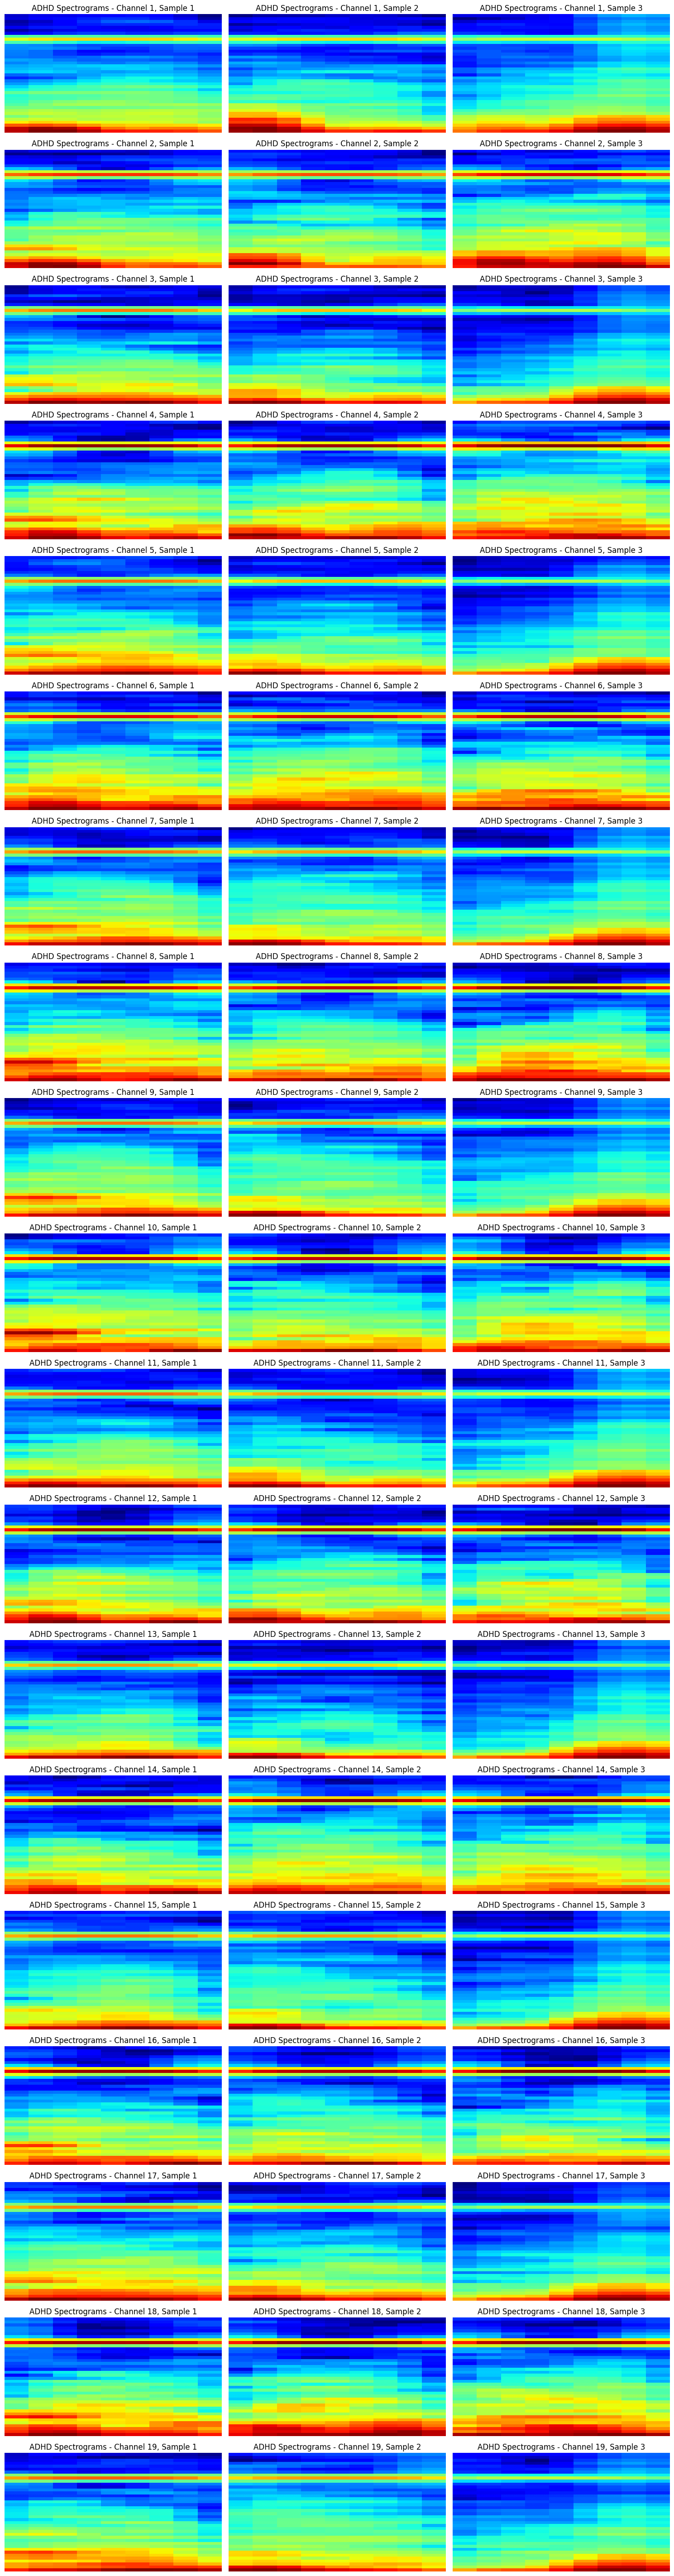

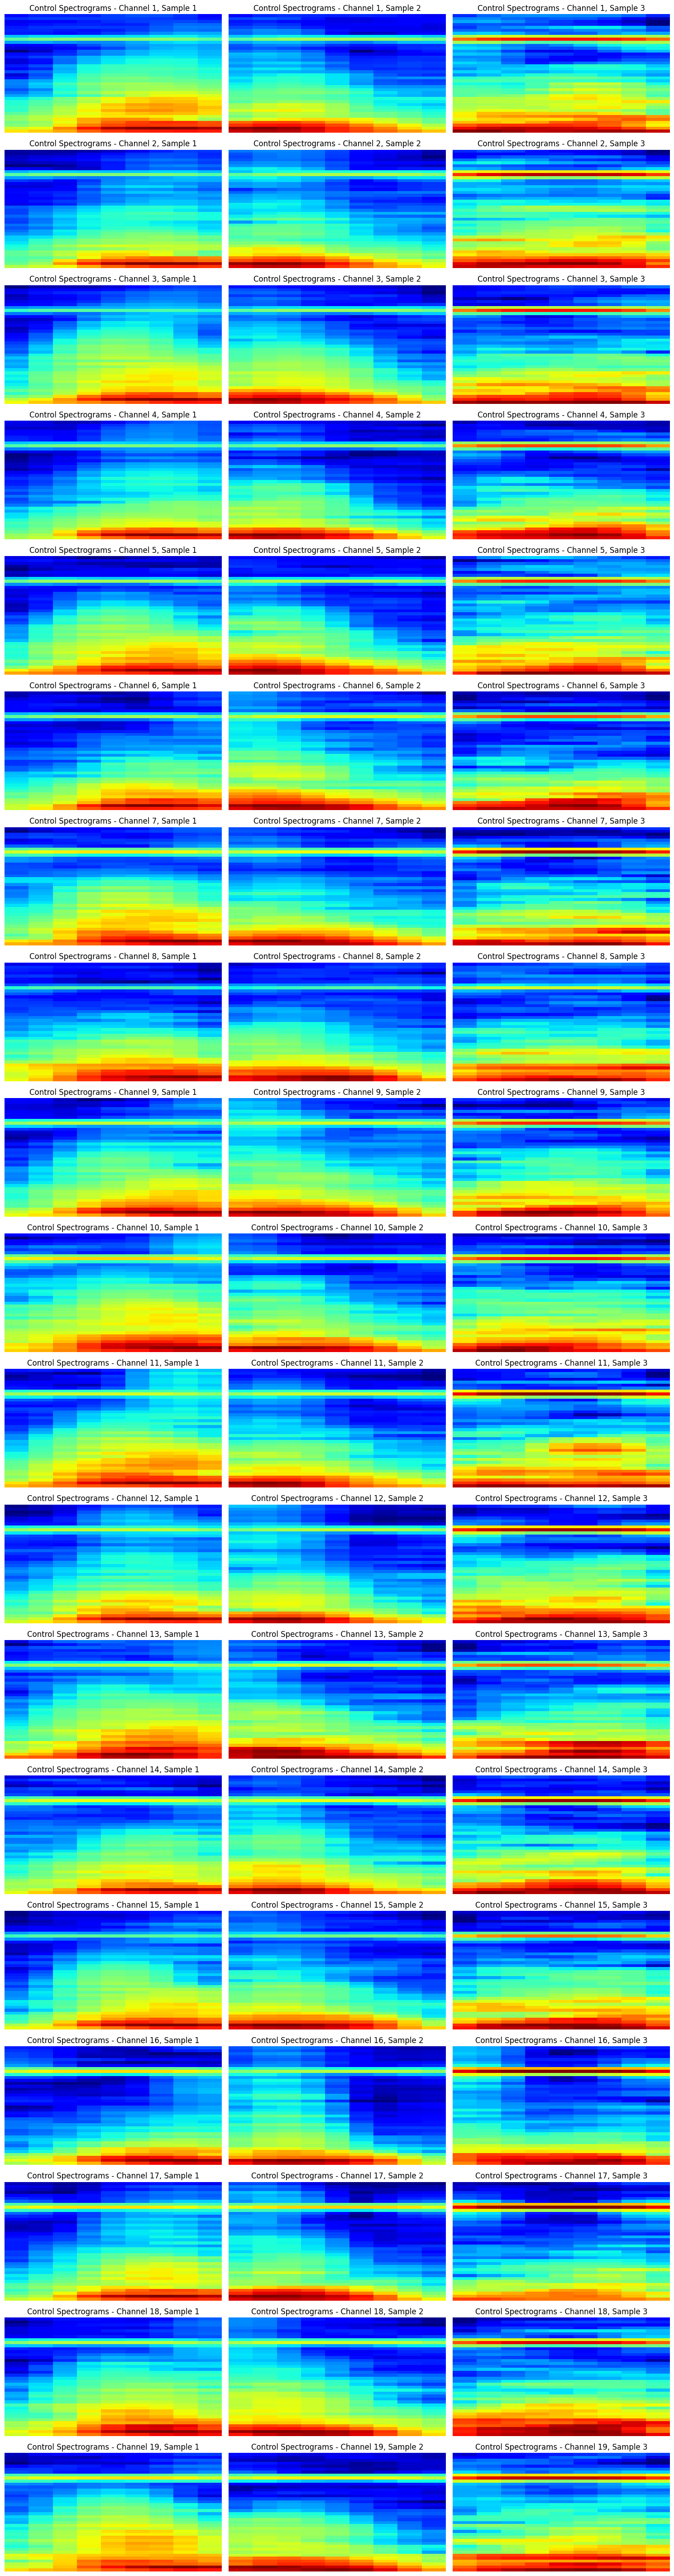

In [10]:
import matplotlib.pyplot as plt

def visualize_spectrograms(spectrograms, title_prefix, num_samples=3):
    num_channels = len(spectrograms)
    fig, axes = plt.subplots(num_channels, num_samples, figsize=(15, 3 * num_channels))

    for ch in range(num_channels):
        for i in range(num_samples):
            ax = axes[ch, i] if num_samples > 1 else axes[ch]
            ax.imshow(spectrograms[ch][i], aspect='auto', origin='lower', cmap='jet')
            ax.set_title(f"{title_prefix} - Channel {ch+1}, Sample {i+1}")
            ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_spectrograms(adhd_spectrograms_per_channel, "ADHD Spectrograms")
visualize_spectrograms(control_spectrograms_per_channel, "Control Spectrograms")


In [11]:
import numpy as np
from sklearn.model_selection import train_test_split


adhd_labels = np.ones((2330, 1))
control_labels = np.zeros((1843, 1))

channel_data = {}

for ch in range(19):

    adhd_ch_data = adhd_spectrograms_per_channel[ch]
    control_ch_data = control_spectrograms_per_channel[ch]


    X = np.vstack((adhd_ch_data, control_ch_data))
    y = np.vstack((adhd_labels, control_labels))


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


    channel_data[ch] = {
        "X_train": X_train, "X_test": X_test,
        "y_train": y_train, "y_test": y_test
    }

    print(f"Channel {ch+1}: Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")



Channel 1: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 2: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 3: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 4: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 5: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 6: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 7: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 8: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 9: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 10: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 11: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 12: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 13: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 14: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 15: Train Shape: (3338, 40, 9), Test Shape: (835, 40, 9)
Channel 16: Train Shape: (3338, 40

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

def build_cnn_model(input_shape):
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0008)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0008)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.0008)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0008)),
        layers.Dropout(0.4),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

trained_models = {}

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

for ch in range(19):
    print(f"Training model for Channel {ch+1}...")

    X_train, X_test = channel_data[ch]["X_train"], channel_data[ch]["X_test"]
    y_train, y_test = channel_data[ch]["y_train"], channel_data[ch]["y_test"]

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    X_train = data_augmentation(X_train)

    input_shape = X_train.shape[1:]
    model = build_cnn_model(input_shape)

    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
              callbacks=[early_stopping, reduce_lr], verbose=1)

    model.save(f"channel_{ch+1}_model.keras")
    trained_models[ch] = model

    print(f"Model for Channel {ch+1} trained and saved.\n")


Training model for Channel 1...
Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.6380 - loss: 1.4326 - val_accuracy: 0.6587 - val_loss: 1.1430 - learning_rate: 3.0000e-04
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7224 - loss: 1.0586 - val_accuracy: 0.7126 - val_loss: 1.0380 - learning_rate: 3.0000e-04
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7257 - loss: 1.0121 - val_accuracy: 0.7497 - val_loss: 0.9725 - learning_rate: 3.0000e-04
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7440 - loss: 0.9720 - val_accuracy: 0.7449 - val_loss: 0.9379 - learning_rate: 3.0000e-04
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7197 - loss: 0.9629 - val_accuracy: 0.7449 - val_loss: 0.9419 - learning_rate: 3.0000e-04
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7484 - loss: 0.9124 - val_accuracy: 0.7557 - val_loss: 1.0580 - learning_rate: 3.0000e-04
Epoch 7/50
105/105 ━━━━━━━━━━


Evaluating model for Channel 1...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 1 Evaluation Metrics:
Accuracy: 0.7449
Precision: 0.7279
Recall: 0.8670
F1 Score: 0.7914
AUC Score: 0.8340


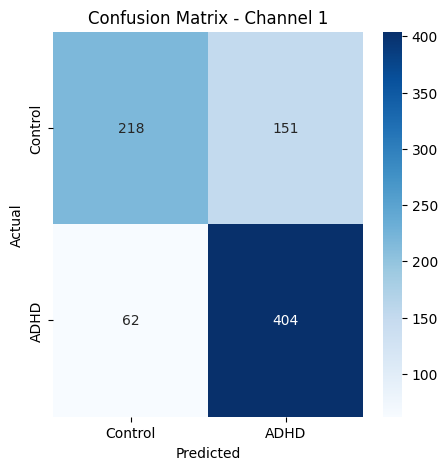


Evaluating model for Channel 2...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Channel 2 Evaluation Metrics:
Accuracy: 0.7425
Precision: 0.7363
Recall: 0.8391
F1 Score: 0.7844
AUC Score: 0.8390


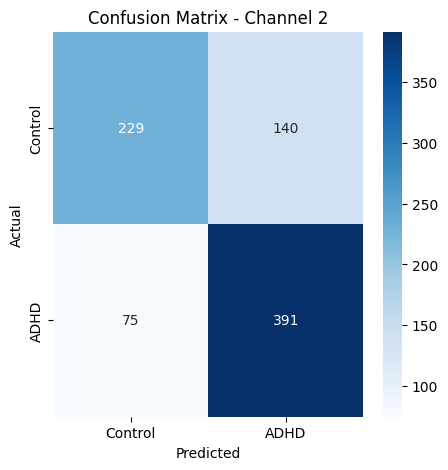


Evaluating model for Channel 3...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Channel 3 Evaluation Metrics:
Accuracy: 0.7557
Precision: 0.7848
Recall: 0.7747
F1 Score: 0.7797
AUC Score: 0.8518


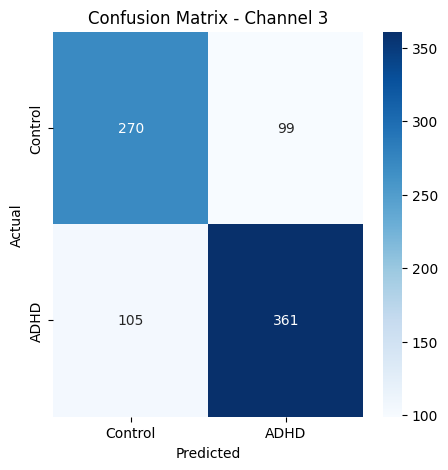


Evaluating model for Channel 4...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 4 Evaluation Metrics:
Accuracy: 0.7473
Precision: 0.7233
Recall: 0.8863
F1 Score: 0.7965
AUC Score: 0.8397


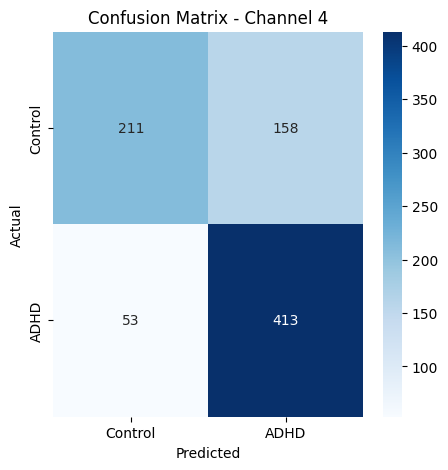


Evaluating model for Channel 5...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 5 Evaluation Metrics:
Accuracy: 0.7497
Precision: 0.7565
Recall: 0.8133
F1 Score: 0.7839
AUC Score: 0.8323


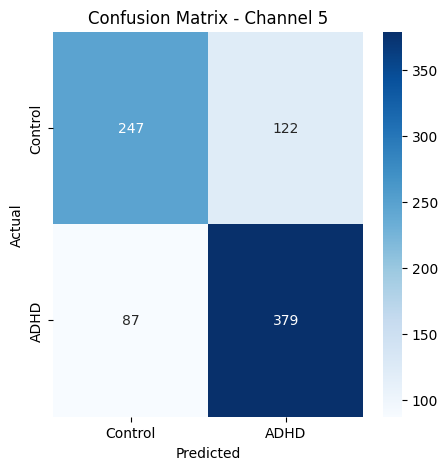


Evaluating model for Channel 6...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Channel 6 Evaluation Metrics:
Accuracy: 0.7186
Precision: 0.7924
Recall: 0.6717
F1 Score: 0.7271
AUC Score: 0.8102


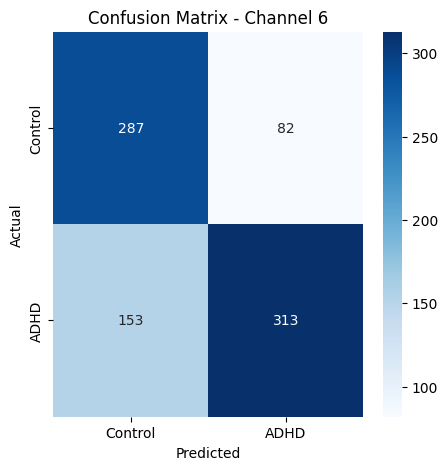


Evaluating model for Channel 7...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 7 Evaluation Metrics:
Accuracy: 0.7808
Precision: 0.8180
Recall: 0.7811
F1 Score: 0.7991
AUC Score: 0.8573


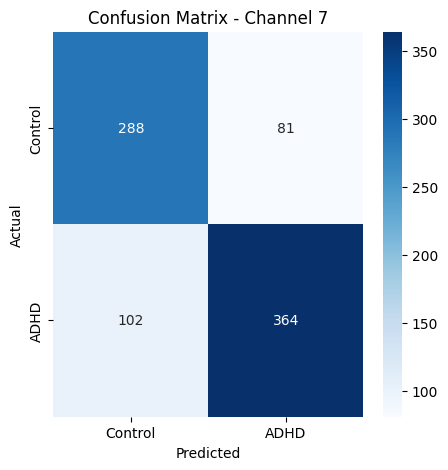


Evaluating model for Channel 8...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Channel 8 Evaluation Metrics:
Accuracy: 0.6922
Precision: 0.7053
Recall: 0.7704
F1 Score: 0.7364
AUC Score: 0.7741


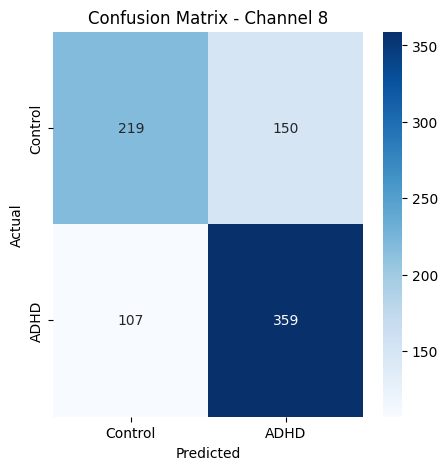


Evaluating model for Channel 9...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Channel 9 Evaluation Metrics:
Accuracy: 0.7317
Precision: 0.7775
Recall: 0.7275
F1 Score: 0.7517
AUC Score: 0.8233


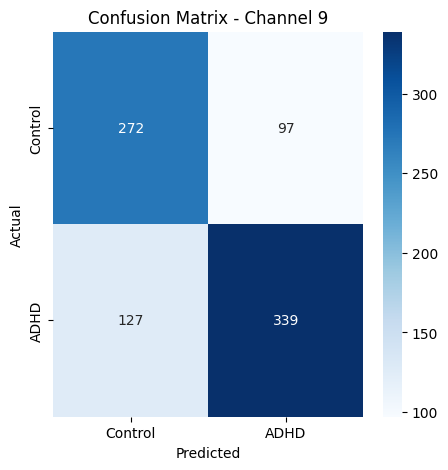


Evaluating model for Channel 10...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 10 Evaluation Metrics:
Accuracy: 0.7413
Precision: 0.7461
Recall: 0.8133
F1 Score: 0.7782
AUC Score: 0.8174


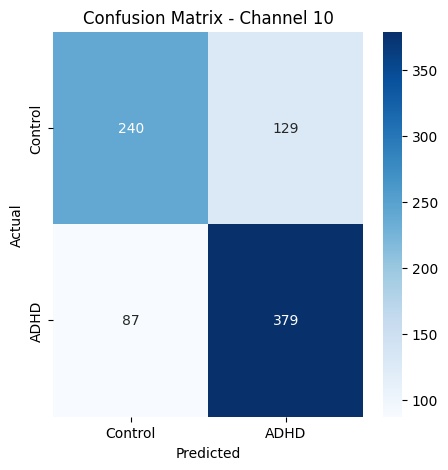


Evaluating model for Channel 11...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 11 Evaluation Metrics:
Accuracy: 0.7701
Precision: 0.8186
Recall: 0.7554
F1 Score: 0.7857
AUC Score: 0.8576


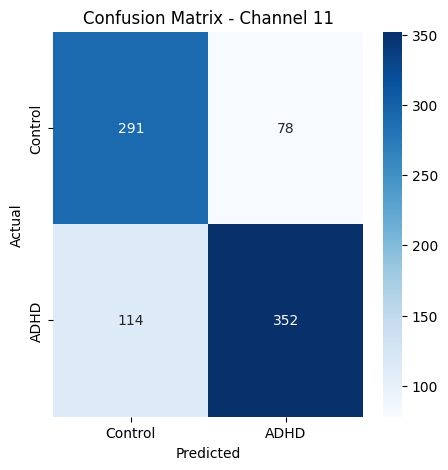


Evaluating model for Channel 12...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 12 Evaluation Metrics:
Accuracy: 0.7737
Precision: 0.7589
Recall: 0.8712
F1 Score: 0.8112
AUC Score: 0.8438


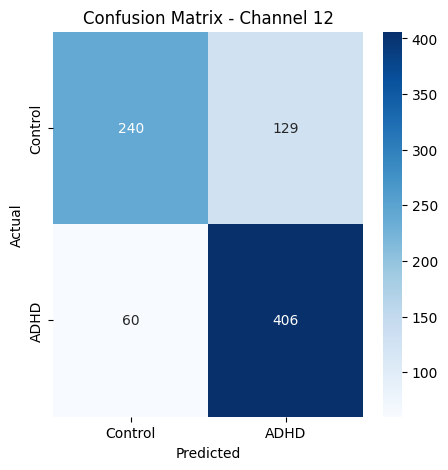


Evaluating model for Channel 13...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 13 Evaluation Metrics:
Accuracy: 0.7737
Precision: 0.7966
Recall: 0.7983
F1 Score: 0.7974
AUC Score: 0.8641


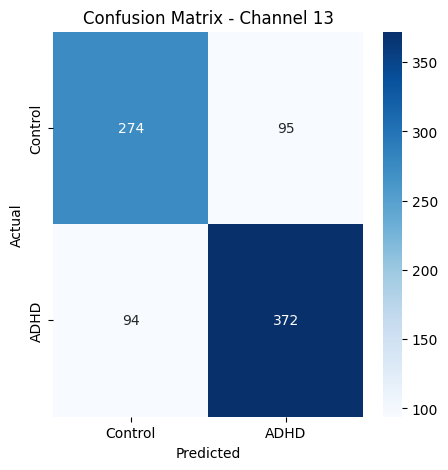


Evaluating model for Channel 14...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 14 Evaluation Metrics:
Accuracy: 0.6874
Precision: 0.7195
Recall: 0.7210
F1 Score: 0.7203
AUC Score: 0.7767


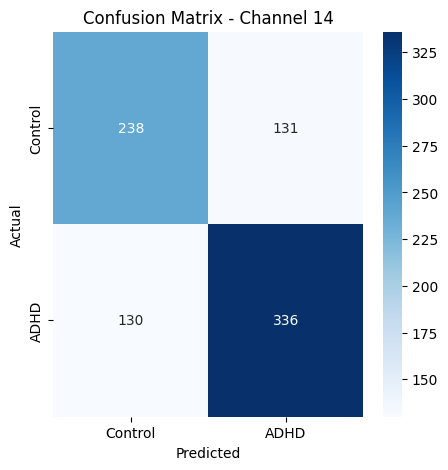


Evaluating model for Channel 15...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 15 Evaluation Metrics:
Accuracy: 0.7425
Precision: 0.7642
Recall: 0.7790
F1 Score: 0.7715
AUC Score: 0.8425


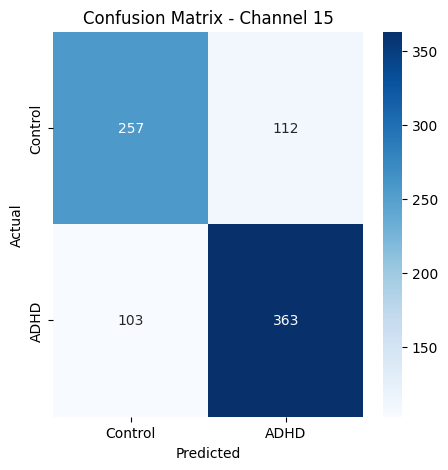


Evaluating model for Channel 16...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Channel 16 Evaluation Metrics:
Accuracy: 0.6731
Precision: 0.6627
Recall: 0.8433
F1 Score: 0.7422
AUC Score: 0.7444


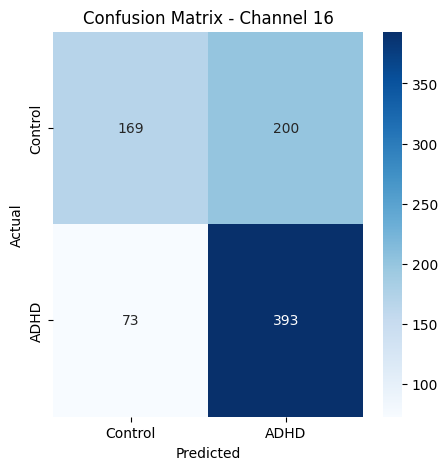


Evaluating model for Channel 17...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Channel 17 Evaluation Metrics:
Accuracy: 0.7916
Precision: 0.8230
Recall: 0.7983
F1 Score: 0.8105
AUC Score: 0.8642


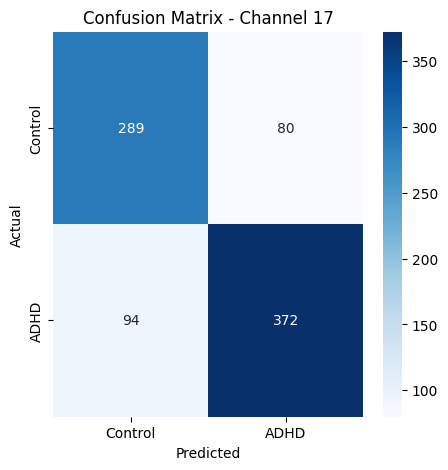


Evaluating model for Channel 18...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 18 Evaluation Metrics:
Accuracy: 0.7461
Precision: 0.7602
Recall: 0.7961
F1 Score: 0.7778
AUC Score: 0.8396


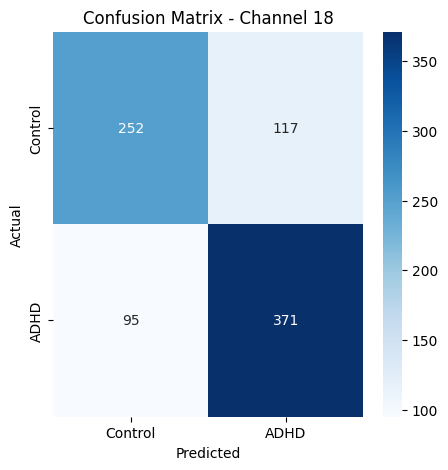


Evaluating model for Channel 19...

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Channel 19 Evaluation Metrics:
Accuracy: 0.7892
Precision: 0.7947
Recall: 0.8391
F1 Score: 0.8163
AUC Score: 0.8685


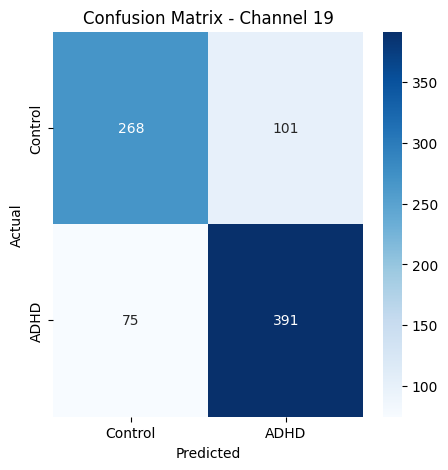

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for ch in range(19):
    print(f"\nEvaluating model for Channel {ch+1}...\n")

    X_test = channel_data[ch]["X_test"]
    y_test = channel_data[ch]["y_test"]

    X_test = X_test[..., np.newaxis]

    model = tf.keras.models.load_model(f"channel_{ch+1}_model.keras")

    y_pred_probs = model.predict(X_test).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_probs)

    print(f"Channel {ch+1} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Control', 'ADHD'], yticklabels=['Control', 'ADHD'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Channel {ch+1}")
    plt.show()


In [16]:
import scipy.io
import numpy as np
import tensorflow as tf
import librosa
from google.colab import files

channel_labels = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T7", "T8", "P7", "P8", "Fz", "Cz", "Pz"
]

model_dir = "/content/drive/My Drive/19_model_trained"
segment_size = 512

def compute_log_mel_spectrogram(segment, sr=128, n_mels=40, n_fft=512, hop_length=64):
    segment = segment.astype(np.float32)
    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return np.expand_dims(log_spectrogram, axis=-1)

def process_and_classify(file_path):
    try:
        data = scipy.io.loadmat(file_path)
    except Exception as e:
        print(f"❌ Error loading .mat file: {e}")
        return

    ignore_keys = ['__header__', '__version__', '__globals__']
    eeg_key = next((key for key in data.keys() if key not in ignore_keys), None)

    if eeg_key:
        eeg_signals = data[eeg_key]
        print(f"✅ Found EEG data under key: {eeg_key}")
    else:
        print("❌ No valid EEG data found in the file.")
        return

    if eeg_signals.shape[1] == 19 and eeg_signals.shape[0] != 19:
        eeg_signals = eeg_signals.T
        print("🔄 Transposed EEG data to match expected shape.")

    if eeg_signals.shape[0] != 19:
        print(f"⚠️ Warning: Incorrect shape {eeg_signals.shape}, check the file format.")
        return

    print(f"✅ EEG Data Loaded Successfully! Shape: {eeg_signals.shape}")

    num_segments = eeg_signals.shape[1] // segment_size
    adhd_votes = 0
    control_votes = 0
    adhd_voting_channels = []
    control_voting_channels = []

    for ch in range(19):
        model_path = f"{model_dir}/channel_{ch+1}_model.keras"
        model = tf.keras.models.load_model(model_path)

        channel_data = eeg_signals[ch, :num_segments * segment_size].reshape(num_segments, segment_size)

        segment_preds = []
        for segment in channel_data:
            mel_spectrogram = compute_log_mel_spectrogram(segment)
            X_test = np.expand_dims(mel_spectrogram, axis=0)

            y_pred_prob = model.predict(X_test)[0, 0]
            y_pred = int(y_pred_prob > 0.5)
            segment_preds.append(y_pred)

        channel_vote = max(set(segment_preds), key=segment_preds.count)

        if channel_vote == 1:
            adhd_votes += 1
            adhd_voting_channels.append(channel_labels[ch])
        else:
            control_votes += 1
            control_voting_channels.append(channel_labels[ch])

    final_class = "ADHD" if adhd_votes >= 10 else "Control"

    print("\n🔹 Final Classification Based on Majority Voting:")
    print(f"🧠 ADHD Votes: {adhd_votes} | 🧠 Control Votes: {control_votes}")
    print(f"✅ Predicted Class: {final_class}")
    print(f"Channels Voting for ADHD: {', '.join(adhd_voting_channels)}")
    print(f"Channels Voting for Control: {', '.join(control_voting_channels)}")

while True:
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]
    process_and_classify(file_path)

    user_input = input("\nDo you want to upload another file for classification? (yes/no): ").strip().lower()
    if user_input != "yes":
        print("✅ Exiting program. Thank you!")
        break



Saving v1p.mat to v1p.mat
✅ Found EEG data under key: v1p
🔄 Transposed EEG data to match expected shape.
✅ EEG Data Loaded Successfully! Shape: (19, 12258)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━

In [18]:
!pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 69.3 MB/s eta 0:00:00


Saving v8p.mat to v8p.mat
✅ Found EEG data under key: v8p
🔄 Transposed EEG data to match expected shape.
✅ EEG Data Loaded Successfully! Shape: (19, 15776)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━

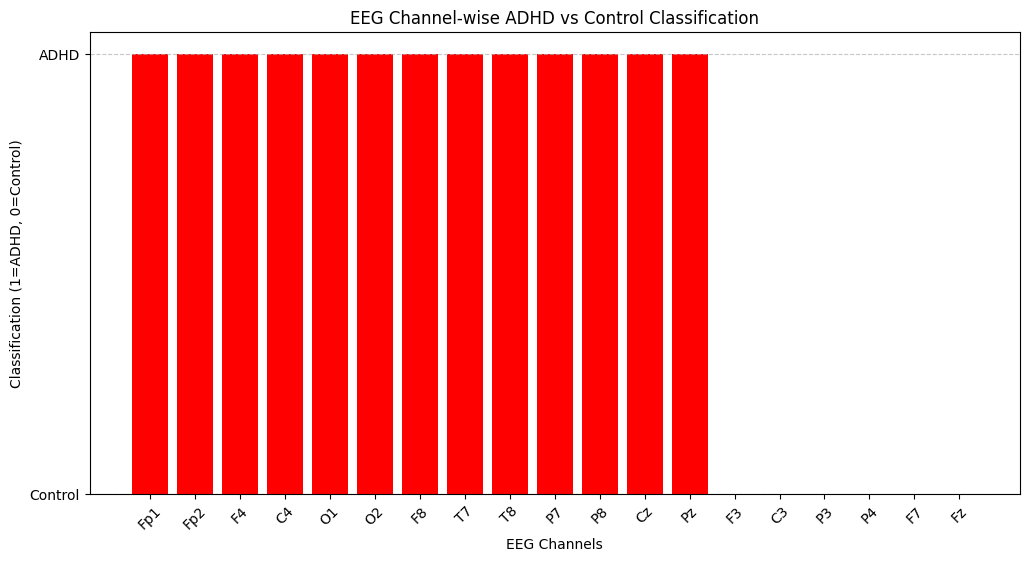

In [ ]:
import scipy.io
import numpy as np
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt
from google.colab import files

channel_labels = [
    "Fp1", "Fp2", "F3", "F4", "C3", "C4", "P3", "P4", "O1", "O2",
    "F7", "F8", "T7", "T8", "P7", "P8", "Fz", "Cz", "Pz"
]

model_dir = "/content/drive/My Drive/19_model_trained"
segment_size = 512

def compute_log_mel_spectrogram(segment, sr=128, n_mels=40, n_fft=512, hop_length=64):
    segment = segment.astype(np.float32)
    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return np.expand_dims(log_spectrogram, axis=-1)

def visualize_channel_votes(adhd_channels, control_channels):
    """Displays a bar chart showing which EEG channels indicate ADHD vs. Control."""
    all_channels = adhd_channels + control_channels
    votes = [1] * len(adhd_channels) + [0] * len(control_channels)

    plt.figure(figsize=(12, 6))
    colors = ["red" if vote == 1 else "green" for vote in votes]
    plt.bar(all_channels, votes, color=colors)

    plt.xlabel("EEG Channels")
    plt.ylabel("Classification (1=ADHD, 0=Control)")
    plt.title("EEG Channel-wise ADHD vs Control Classification")
    plt.xticks(rotation=45)
    plt.yticks([0, 1], ["Control", "ADHD"])
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()

def process_and_classify(file_path):
    try:
        data = scipy.io.loadmat(file_path)
    except Exception as e:
        print(f"❌ Error loading .mat file: {e}")
        return

    ignore_keys = ['__header__', '__version__', '__globals__']
    eeg_key = next((key for key in data.keys() if key not in ignore_keys), None)

    if eeg_key:
        eeg_signals = data[eeg_key]
        print(f"✅ Found EEG data under key: {eeg_key}")
    else:
        print("❌ No valid EEG data found in the file.")
        return

    if eeg_signals.shape[1] == 19 and eeg_signals.shape[0] != 19:
        eeg_signals = eeg_signals.T
        print("🔄 Transposed EEG data to match expected shape.")

    if eeg_signals.shape[0] != 19:
        print(f"⚠️ Warning: Incorrect shape {eeg_signals.shape}, check the file format.")
        return

    print(f"✅ EEG Data Loaded Successfully! Shape: {eeg_signals.shape}")

    num_segments = eeg_signals.shape[1] // segment_size
    adhd_votes = 0
    control_votes = 0
    adhd_voting_channels = []
    control_voting_channels = []

    for ch in range(19):
        model_path = f"{model_dir}/channel_{ch+1}_model.keras"
        model = tf.keras.models.load_model(model_path)

        channel_data = eeg_signals[ch, :num_segments * segment_size].reshape(num_segments, segment_size)

        segment_preds = []
        for segment in channel_data:
            mel_spectrogram = compute_log_mel_spectrogram(segment)
            X_test = np.expand_dims(mel_spectrogram, axis=0)

            y_pred_prob = model.predict(X_test)[0, 0]
            y_pred = int(y_pred_prob > 0.5)
            segment_preds.append(y_pred)

        channel_vote = max(set(segment_preds), key=segment_preds.count)

        if channel_vote == 1:
            adhd_votes += 1
            adhd_voting_channels.append(channel_labels[ch])
        else:
            control_votes += 1
            control_voting_channels.append(channel_labels[ch])

    final_class = "ADHD" if adhd_votes >= 10 else "Control"

    print("\n🔹 Final Classification Based on Majority Voting:")
    print(f"🧠 ADHD Votes: {adhd_votes} | 🧠 Control Votes: {control_votes}")
    print(f"✅ Predicted Class: {final_class}")
    print(f"Channels Voting for ADHD: {', '.join(adhd_voting_channels)}")
    print(f"Channels Voting for Control: {', '.join(control_voting_channels)}")

    # 🔹 Visualizing ADHD vs Control Channels
    visualize_channel_votes(adhd_voting_channels, control_voting_channels)

while True:
    uploaded = files.upload()
    file_path = list(uploaded.keys())[0]
    process_and_classify(file_path)

    user_input = input("\nDo you want to upload another file for classification? (yes/no): ").strip().lower()
    if user_input != "yes":
        print("✅ Exiting program. Thank you!")
        break
